# Import packages

In [808]:
# Data packages
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import math

# TensorFlow packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers import Dense

# Graphical/Geo packages
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
#import IPython
import censusdata
import geopy

np.set_printoptions(precision=4)

# Read In Hud Data, drop excess columns, and replace missing records with NaN

In [809]:
df = pd.read_csv('ah_hud_va.csv')
exclude_cols = ['Congressional District','CBSA','PLACE','State','PHA Total Units','HA category']
df = df[[i[1] for i in enumerate(df.columns) if i[0]>6 and i[1] not in exclude_cols]]
df = df.replace(-4,np.nan)

# Create function to convert lat/long to zip

In [810]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']

# Get zip codes for the HuD dataset

In [811]:
geolocator = geopy.Nominatim(user_agent='me')
df_lat = df[['Latitude','Longitude']].dropna().reset_index(drop=True).drop_duplicates()
df_lat['zip_code'] = df_lat.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Latitude', lon_field='Longitude')
df_lat['zip_code'] = df_lat['zip_code'].apply(lambda x: str(x)[:5])

# Read in VA zip code file

In [812]:
df_zips = pd.read_csv('zipcodes.csv')
df_zips['zip_code'] = df_zips['zip_code'].apply(lambda x:str(x))
df_zips = pd.merge(df_zips,df_lat,left_on='zip_code',right_on='zip_code',how='outer').drop_duplicates()

# Query US census dataset for all 2018 fields with income in the description

In [813]:
col_dict = {i[0]:[i[1],i[2]] for i in censusdata.search('acs5', 2018,'concept', 'income') if i[0][-1]=='E'}

# Look up all counties in VA according to census dataset

In [814]:
counties = censusdata.geographies(censusdata.censusgeo([('state', '51'), ('county', '*')]), 'acs5', 2018)

# Pull income data fields by county from the census data

In [815]:
base_to_drop = ['B19123','B26216','B28004','B29004','C27016','C27017','C27018']
keys_to_use = [i for i in list(col_dict.keys()) if i[:6] not in base_to_drop]
data = censusdata.download('acs5', 2015,
           censusdata.censusgeo([('state', '51'),
                                 ('county', '*')]),
                           keys_to_use)

# Clean census dataset and add county names

In [816]:
data.reset_index(inplace=True)
data['County'] = data['index'].apply(lambda x: str(x)[:str(x).find(' County')])
data['County'] = np.where(data['County'].str.find('city')>=0,'City of '+data['County'],data['County'])
data['County'] = np.where(data['County'].str.find(' city')>=0,data['County'].apply(lambda x: str(x)[:str(x).find(' city')]),data['County'])
del data['index']

# Add zipcodes to the census dataset

In [817]:
df_zipsdata = pd.merge(df_zips[['zip_code','County']],data,left_on='County',right_on='County').drop_duplicates()
df_zipsdata['zip_code'] = df_zipsdata['zip_code'].apply(lambda x: str(x))

# Add counties and subsidized housing data to the census dataset

In [818]:
df_agg = pd.merge(df_lat,df,left_on=['Latitude','Longitude'],right_on=['Latitude','Longitude'])[['zip_code','Subsidized units available']]
df_agg['zip_code'] = df_agg['zip_code'].apply(lambda x: str(x))
df_agg = df_agg.groupby('zip_code').sum().reset_index()
df_agg = pd.merge(df_agg,df_zipsdata[['zip_code','County']],left_on='zip_code',right_on='zip_code',how='outer').drop_duplicates().groupby('County').sum().reset_index()
del df_zipsdata['zip_code']
df_agg = pd.merge(df_zipsdata,df_agg,left_on='County',right_on='County').drop_duplicates()
df_agg.set_index('County',inplace=True)
df_agg.dropna(axis=1,how='any',inplace=True)
df_agg = df_agg.loc[:, df_agg.std() > 0]

# Data Acquisition complete

# Split data into train and test 

In [930]:
train_ratio = 0.8

# train is now 80% of the entire data set
df_train, df_test = train_test_split(df_agg, test_size=1 - train_ratio,random_state=49)

## Standard scale columns

In [931]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
features = [i for i in df_agg.columns if i != list(df_agg.columns)[-1]]
scalar = StandardScaler()
old_shape_train = df_train.shape
old_shape_test = df_test.shape

# the fit_transform ops returns a 2d numpy.array, we cast it to a pd.DataFrame
standardized_features_train = pd.DataFrame(scalar.fit_transform(df_train[features].copy()), columns = features,index=df_train.index)
standardized_features_test = pd.DataFrame(scalar.fit_transform(df_test[features].copy()), columns = features,index=df_test.index)

# drop the unnormalized features from the dataframe
df_train.drop(features, axis = 1, inplace = True)
df_test.drop(features, axis = 1, inplace = True)

# join back the normalized features
df_train = pd.concat([standardized_features_train, df_train], axis= 1)
df_test = pd.concat([standardized_features_test, df_test], axis= 1)

# Assert if something goes wrong
assert old_shape_train == df_train.shape, "something went wrong!"
assert old_shape_test == df_test.shape, "something went wrong!"

/Users/spencermarusco/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# Read train and test df into tf objects and shuffle/batch

In [932]:
train_dataset = tf.data.Dataset.from_tensor_slices((df_train.values[:,0:2500], df_train.values[:,2500]))
test_dataset = tf.data.Dataset.from_tensor_slices((df_test.values[:,0:len(df_test.columns)-1], df_test.values[:,len(df_test.columns)-1]))
train_dataset = train_dataset.shuffle(len(df_train)).batch(1)
test_dataset = test_dataset.shuffle(len(df_test)).batch(1)

# Define helper functions for callbacks

In [933]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=50)

# Build model

In [971]:
def build_model():
    model = Sequential()
    model.add(Dense(128, input_dim=df_train.values[:,0:len(df_train.columns)-1].shape[1], activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='Adam', 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

# Fit model

In [972]:
model = build_model()
history = model.fit(train_dataset, epochs=100, verbose=0, callbacks=[early_stop, PrintDot()])


....................................................................................................

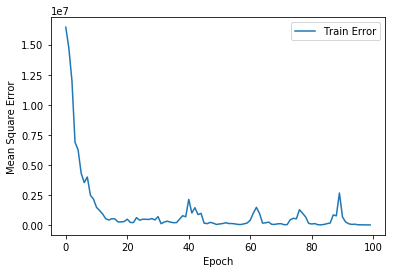

In [973]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.legend()

plot_history()

# Validate model against test dataset

In [974]:
loss, mae, mse = model.evaluate(test_dataset)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

24/24 [==============================] - 0s 2ms/step - loss: 2317530.7500 - mae: 1037.4952 - mse: 2317530.7500
Root Mean Square Error on test set: 1522.344


In [ ]:
model.save('model.keras')

In [ ]:
saved_model = tf.keras.models.load_model('model.keras')